# Part Processing Classification

***
### Name: Tim Fuger
### Date: 5/12/23
***

# Business Understanding

## Background

Manufacturing as a whole has the second largest potential for automation in the industry. This is according to Mckinsey from an article in 2017 titles "Human + machine" which outlined an analysis on the industry (see the chart below which measured the manufacturing work in 46 different countries covering about 80 percent of the global workforce):

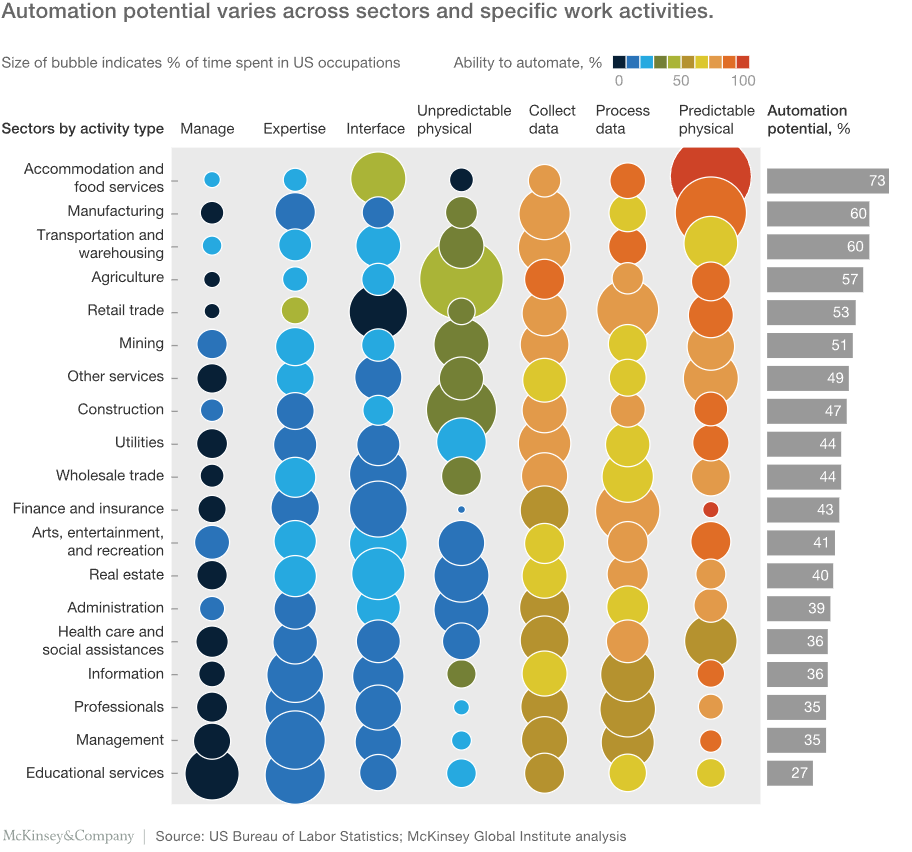

https://www.mckinsey.com/capabilities/operations/our-insights/human-plus-machine-a-new-era-of-automation-in-manufacturing#/

According to ther article, in manufacturing "87 percent of hours are spent on activities performed by workers in production occupations [which] are automatable." Since then manufacturing has begun to automate these production occupation hours, but what has changed since then is the rapid development of AI technologies. These developments could help not only the production departments buyt other departments as well. In engineering pecifically, Mckinsey estimates that 45 percent of working hours are automatable. Cutting down on any of this time would boost effiencies in any company exponentially.

## Business Problem

> Our stakeholder is looking to **reduce engineering time** to **assign the manufacturing process** for a custom fabricated **part**.

Our client has already worked to automate large portions of the shop/production floor by having robots and more sophisticated machinery and software work in tandem with shop employees. Since upgrading production equipment and processes, they have seen the bottleneck in their facility start to shift from the production departments to their engineering and design departments. With the increased efficiency in production, the shop floor is always ahead of engineering and design, which means that the shop is consistently waiting on digital files and shop documentation in order to continue working on projects. They would like to boost the automation in the engineering and design departments.

Our client's long term goal is to create a system which can automatically identify and program parts for various assemblies. This in turn will reduce the amount of engineering time required for each project, and will free the team up to focus on other responsibilities. For this project is the catalyst of this long term goal. It will start by classifying the first step in the manufacturing process for each of the parts.

## Objective

> To develop a **graph nueral network** that can properly **identify** the **required processes** for each **3D modeled part**.

## Defining Metrics

The metric that is most important in our analysis is precision. We need to be really precise in our predictions, as an imprecise prediction means a material gets sent to the wrong workcell. This, at the least, means lost time for sending the material back to the previous station, but, at the worst, it could mean lost time and lost material if someone cuts stock they should not be cutting.

Our second metric to use (should there be only slight precision differences between models) will be F1-score. This will help us to balance precision against recall as we analyze the models.

## The Dataset

The dataset contains around 1000 models which are all parametric variations on 10 different types of fixtures. Each fixture is made up of a variety of parts, with each part having a different shape and a different material assigned. The parts make up assemblies which are identified and shown in the table below.

| Assembly  | Type  |
|---|---|
| Cab1  | Base Cabinet  |
| Cab2  | Wall Cabinet  |
| Cab3  | Pantry Cabinet  |
| Shelf1  | Removable Shelf  |
| Shelf2  | Floating Shelf  |
| Counter1  | Order Counter  |
| Station1  | Utensil Station  |
| Bench1  | Bench with back  |
| Bench2  | Bench with no back  |
| Table1  | Table  |

All of the original solidworks models of these assemblies are located in the SW_Models folder. Each of these solidworks models have a design table which has multiple configurations of each assembly. For example, Station2 has 21 configurations of its model (not including the default configuration which was not used in this project). Each of these configurations have a different length, and width so as to create varied parts for the models to process. All of the different variations and the attributes of each are detailed in the file "Part_classification-Variations.csv" file.

After all of the models and configurations were setup, each of the solidworks models were converted to meshes by using a well built script by SigmaRelief off of github, which you can find at the link below:

https://github.com/SigmaRelief/SOLIDWORKS-Export-to-Mesh

All of these converted meshes were stored in the Meshes folder of this repo. The naming convention of the meshes used the following default naming strategy:

*Assembly-Configuration - PartName*

Example:
The first part of the first configuration of Bench1 is:

Bench1-01 - Bench1-01-1


## Modeling

TBD

# Data Understanding

## Reading and Analyzing the Data

We will start by importing the libraries required for the notebook and pulling in the data:

In [2]:
#import all necessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_theme()
sns.set(rc={'savefig.dpi':300, 'figure.figsize':(12,8)})
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import trimesh
import numpy as np

# import meshplot as mp
import torch
from pathlib import Path
# from torch_geometric.data import data
# from torch_geometric.loader import DataLoader
# from mpl_toolkits import mplot3d

C:\Users\Tim\anaconda3\envs\pytorch3d\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# https://colab.research.google.com/drive/1Uds5r4QWcB5bsELiyBM8TBHEHFVCVcd3?usp=sharing#scrollTo=gr6HXz0qqSxd
# https://medium.com/stanford-cs224w/deep-learning-on-3d-meshes-9608a5b33c98

# # Define a function called load_mesh, which will take the mesh file

# def load_mesh(mesh_filename: Path):
#     """Extract vertices and faces from raw mesh file.

#     Parameters
#     ----------
#     mesh_filename: PathLike
#         Path to mesh `.ply` file.

#     Returns
#     -------
#     vertices: torch.tensor
#         Float tensor of size (|V|, 3), where each row
#         specifies the spatial position of a vertex in 3D space.
#     faces: torch.tensor
#         Intger tensor of size (|M|, 3), where each row
#         defines a traingular face.
#     """
#     mesh = trimesh.load_mesh(mesh_filename, process=False)
#     vertices = torch.from_numpy(mesh.vertices).to(torch.float)
#     faces = torch.from_numpy(mesh.faces)
#     faces = faces.t().to(torch.long).contiguous()
#     return vertices, faces

In [4]:
mesh = trimesh.load_mesh("Meshes/0_FabInc_NoClass/Bench1-01 - Bench1-01-1.stl")
mesh

<trimesh.Trimesh(vertices.shape=(2622, 3), faces.shape=(7644, 3))>

In [5]:
mesh2 = trimesh.load_mesh("Meshes/0_FabInc_NoClass/Bench1-01 - Bench1-02-1.stl")
mesh2

<trimesh.Trimesh(vertices.shape=(8, 3), faces.shape=(12, 3))>

In [6]:
mesh.show()
mesh2.show()

In [7]:
df_target = pd.read_csv('Part_Classification.csv')
df_target

,Iteration,Part Name,Material,Manufacturing Process
0,1.0,Bench1-01,Hot Rolled Steel,Metal Band Saw
1,1.0,Bench1-02,White Oak,Panel Saw
2,1.0,Bench1-03,White Oak,Panel Saw
3,1.0,Bench1-04,White Oak,Panel Saw
4,2.0,Bench1-01,Hot Rolled Steel,Metal Band Saw
...,...,...,...,...
990,24.0,Table1-02,Hot Rolled Steel,Metal Band Saw
991,25.0,Table1-02,Hot Rolled Steel,Metal Band Saw
992,26.0,Table1-02,Hot Rolled Steel,Metal Band Saw
993,27.0,Table1-02,Hot Rolled Steel,Metal Band Saw


Lets take a look at the material types that we have and the manufacturing processes we have.

In [8]:
# Show number of data points of each class
print(df_target['Material'].value_counts())
print(df_target['Manufacturing Process'].value_counts())

TFL                 500
White Oak           235
MDF                  84
Hot Rolled Steel     83
Stainless Steel      75
Caesarstone          18
Name: Material, dtype: int64
CNC               494
Panel Saw         325
Metal Band Saw     80
Metal Laser        78
Waterjet           18
Name: Manufacturing Process, dtype: int64


In [9]:
# Calculate percentages for each class
Value_counts = df_target['Manufacturing Process'].value_counts(normalize=True)*100
Vcts = [round(item, 2) for item in list(Value_counts.to_dict().values())]
Vcts

[49.65, 32.66, 8.04, 7.84, 1.81]

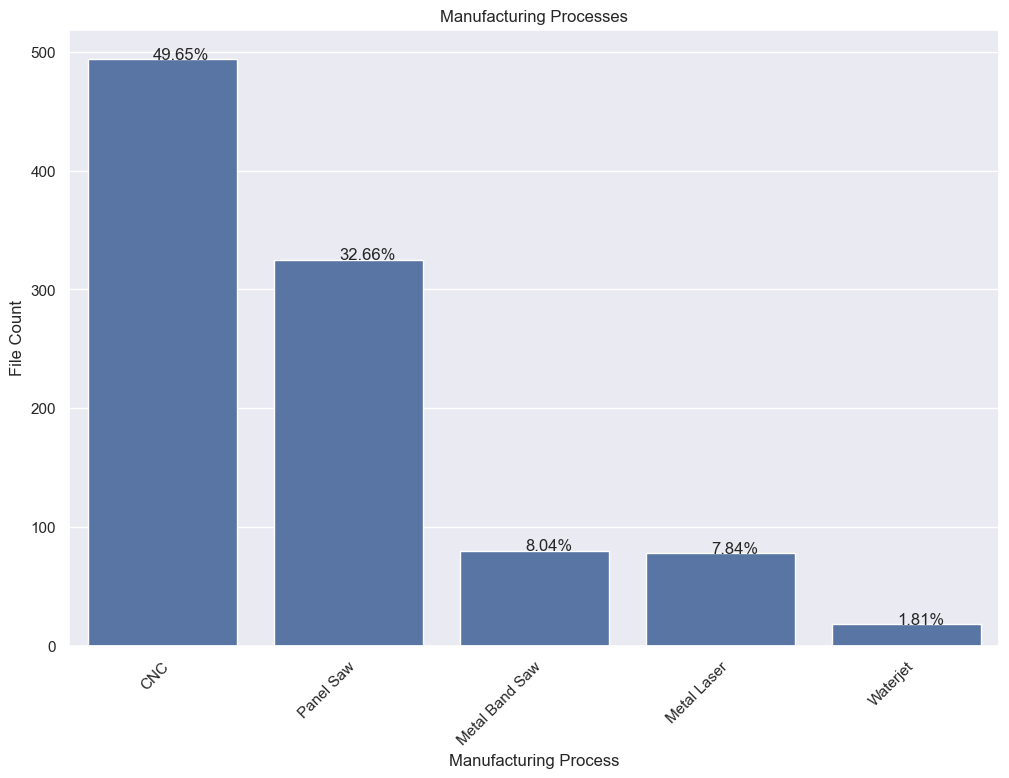

In [10]:
# Plot class types and percentages in barplot

Manu_type = df_target['Manufacturing Process'].value_counts(sort=True)
Value_counts = df_target['Manufacturing Process'].value_counts(normalize=True)*100
vctsdict = Value_counts.to_numpy()

ax = sns.barplot(x=Manu_type.index, y=Manu_type.values, color='b')
ax.set(xlabel='Manufacturing Process', ylabel='File Count', title='Manufacturing Processes')
plt.xticks(rotation=45, ha='right', rotation_mode='anchor')

for val, p in enumerate(ax.patches):
        x = p.get_x() + p.get_width() / 2 - 0.05
        y = p.get_y() + p.get_height()
        ax.annotate((str(Vcts[val]) + '%'), (x, y), size = 12)

plt.savefig('Visualizations/Manufacturing-Processes-Bar-Chart.png', bbox_inches='tight', transparent=True)        
plt.show();

Looks like we have a severe class imbalance. So we will need to do something in our data preparation to adjust for this imbalance.

https://towardsdatascience.com/how-to-create-a-list-of-files-folders-and-subfolders-and-then-export-as-excel-6ce9eaa3867a

In [11]:

import os
import pandas as pd
import sys
import tkinter.filedialog as tkfd

d_ext_desc = {'csv':'CSV file',
              'db':'Thumbnail',
              'doc':'Microsoft Word Document',
              'docx':'Microsoft Word Document',
              'GIF':'GIF Image file',
              'html':'HTML file',
              'ico':'Icon Image file',
              'jpg':'JPG Image file',
              'JPEG':'JPEG Image file',
              'json':'JSON file',
              'lnk':'Shortcut file',
              'msg':'Microsoft Outlook Message file',
              'pdf':'PDF file',
              'pkl':'Pickle (python) file',
              'png':'PNG Image file',
              'ppt':'Microsoft Powerpoint file',
              'pptx':'Microsoft Powerpoint file',
              'pst':'Microsoft Outlook Data file',
              'py':'Python file',
              'pyc':'Python file (compiled)',
              'rtf':'Rich Text Format',
              'svg':'SVG Image file',
              'stl':'Stereolithography Mesh',
              'txt':'Text document',
              'url':'Hyperlink',
              'vsd':'Microsoft Visio file',
              'xls':'Microsoft Excel file',
              'xlsb':'Microsoft Excel file',
              'xlsm':'Microsoft Excel (Macro-enabled) file',
              'xlsx':'Microsoft Excel file',
              'yml':'Requirements file (python)',
              'zip':'ZIP file'}

def ext_desc(ext):
    try:
        desc = d_ext_desc[ext]
    except KeyError:
        desc = ''
    else:
        pass
    return desc

def generate_index(path=None, max=500):
    # stops generating index whenever there are more than 500 records, to test if the script works
    # use 'max=0' to generate the full index
    
    path = path if path else tkfd.askdirectory() # Request path if not provided

    df = pd.DataFrame(columns=['File','File Type','Folder Location','Link','Path'])
    for root, _ , files in os.walk(path):
        files = [f for f in files if not f.startswith('~') and f!='Thumbs.db']
        paths = [os.path.join(root, f) for f in files]
        exts = [os.path.splitext(f)[1][1:].lower() for f in files]
        filetypes = [ext_desc(ext) for ext in exts]
        file_links = ['=HYPERLINK("{}","link")'.format(p) if len(p) < 256 else '' for p in paths]
        folders = [os.path.dirname(p) for p in paths]
        df1 = pd.DataFrame({'File': files,
                            'File Type': filetypes,
                            'Folder Location': folders,
                            'Link': file_links,
                            'Path': paths})
        df = df.append(df1)
        if max and (df.shape[0]>max):
            break
    df = df.reset_index(drop=True)
    return df
  
# if __name__ == '__main__':
#     df = generate_index(path='Meshes/', max=0)
#     df.to_excel('file_index.xlsx')

In [12]:
df_Mesh = generate_index(path='Meshes/0_FabInc_NoClass', max=0)
df_Mesh

C:\Users\Tim\AppData\Local\Temp\ipykernel_15604\1339250314.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(df1)


,File,File Type,Folder Location,Link,Path
0,Bench1-01 - Bench1-01-1.STL,Stereolithography Mesh,Meshes/0_FabInc_NoClass,"=HYPERLINK(""Meshes/0_FabInc_NoClass\Bench1-01 ...",Meshes/0_FabInc_NoClass\Bench1-01 - Bench1-01-...
1,Bench1-01 - Bench1-02-1.STL,Stereolithography Mesh,Meshes/0_FabInc_NoClass,"=HYPERLINK(""Meshes/0_FabInc_NoClass\Bench1-01 ...",Meshes/0_FabInc_NoClass\Bench1-01 - Bench1-02-...
2,Bench1-01 - Bench1-03-1.STL,Stereolithography Mesh,Meshes/0_FabInc_NoClass,"=HYPERLINK(""Meshes/0_FabInc_NoClass\Bench1-01 ...",Meshes/0_FabInc_NoClass\Bench1-01 - Bench1-03-...
3,Bench1-01 - Bench1-04-1.STL,Stereolithography Mesh,Meshes/0_FabInc_NoClass,"=HYPERLINK(""Meshes/0_FabInc_NoClass\Bench1-01 ...",Meshes/0_FabInc_NoClass\Bench1-01 - Bench1-04-...
4,Bench1-02 - Bench1-01-1.STL,Stereolithography Mesh,Meshes/0_FabInc_NoClass,"=HYPERLINK(""Meshes/0_FabInc_NoClass\Bench1-02 ...",Meshes/0_FabInc_NoClass\Bench1-02 - Bench1-01-...
...,...,...,...,...,...
1120,Table1-26 - Table1-02-1.STL,Stereolithography Mesh,Meshes/0_FabInc_NoClass,"=HYPERLINK(""Meshes/0_FabInc_NoClass\Table1-26 ...",Meshes/0_FabInc_NoClass\Table1-26 - Table1-02-...
1121,Table1-27 - Table1-01-1.STL,Stereolithography Mesh,Meshes/0_FabInc_NoClass,"=HYPERLINK(""Meshes/0_FabInc_NoClass\Table1-27 ...",Meshes/0_FabInc_NoClass\Table1-27 - Table1-01-...
1122,Table1-27 - Table1-02-1.STL,Stereolithography Mesh,Meshes/0_FabInc_NoClass,"=HYPERLINK(""Meshes/0_FabInc_NoClass\Table1-27 ...",Meshes/0_FabInc_NoClass\Table1-27 - Table1-02-...
1123,Table1-28 - Table1-01-1.STL,Stereolithography Mesh,Meshes/0_FabInc_NoClass,"=HYPERLINK(""Meshes/0_FabInc_NoClass\Table1-28 ...",Meshes/0_FabInc_NoClass\Table1-28 - Table1-01-...


It looks like we have alot more files than what we have labels for. We have 1125 files and only 995 labels. I think this is probably due to the export function that was used in solidworks. In assemblies such as Cab3, there may be 6 unique parts, but one of the parts is repeated three times in the model (as there are three shelves in that cabinet). We will need to identify which files are duplicates and elminate them from the list in our Data prep phase.

We could probably confirm this by identifying a model which would have this happen. We could use Cab3 as our example to compare the differences between the files and the labels.

In [13]:
df_Mesh_cab3 = df_Mesh[df_Mesh['File'].str.contains('Cab3')]
df_Mesh_cab3[-5:]

,File,File Type,Folder Location,Link,Path
703,Cab3-28 - Cab3-04-1.STL,Stereolithography Mesh,Meshes/0_FabInc_NoClass,"=HYPERLINK(""Meshes/0_FabInc_NoClass\Cab3-28 - ...",Meshes/0_FabInc_NoClass\Cab3-28 - Cab3-04-1.STL
704,Cab3-28 - Cab3-06-1.STL,Stereolithography Mesh,Meshes/0_FabInc_NoClass,"=HYPERLINK(""Meshes/0_FabInc_NoClass\Cab3-28 - ...",Meshes/0_FabInc_NoClass\Cab3-28 - Cab3-06-1.STL
705,Cab3-28 - Cab3-07-1.STL,Stereolithography Mesh,Meshes/0_FabInc_NoClass,"=HYPERLINK(""Meshes/0_FabInc_NoClass\Cab3-28 - ...",Meshes/0_FabInc_NoClass\Cab3-28 - Cab3-07-1.STL
706,Cab3-28 - Cab3-07-2.STL,Stereolithography Mesh,Meshes/0_FabInc_NoClass,"=HYPERLINK(""Meshes/0_FabInc_NoClass\Cab3-28 - ...",Meshes/0_FabInc_NoClass\Cab3-28 - Cab3-07-2.STL
707,Cab3-28 - Cab3-07-3.STL,Stereolithography Mesh,Meshes/0_FabInc_NoClass,"=HYPERLINK(""Meshes/0_FabInc_NoClass\Cab3-28 - ...",Meshes/0_FabInc_NoClass\Cab3-28 - Cab3-07-3.STL


We can even see at the end of the cab3 mesh dataframe that there are three parts of the Cab3-07 part. We only really need one of each part, so as to not have any duplicates in the dataset. Luckily it seems the last number in the file name of the "File" column of the df_mesh dataframe identifies the duplicate instance of the part, so we can use that to create a dataframe that only has a singlke instance of each part.

But this does not match the 995 records we have in the other file either. In looking closer at one of the solidworks files, it looks like some of the parts that have the second number are mirrored parts in the assembly themselves

# Data Preparation

So for the data preparation we will need to do the following:

1. Create a dataframe that does not contain duplicate parts to use in modeling.
2. We will need to assign class weights to counteract the class imbalance in the dataset.
3. The data has to be prepared to be fed into a pytorch model by being batched into native datasets.

We will first compare the file names from the df_mesh frame to our names in the df_target dataframe we have, and see what names are in the csv file that are not in the mesh files.

In [14]:
# Remove file extension from string
df_MeshSplit1 = df_Mesh['File'].str.split('.', expand=True)[0]

# Remove first assembly name
df_MeshSplit2 = df_MeshSplit1.str.split('-', n=1, expand=True)[1]

# For any string that has more than 2 '-' characters (solidworks assembly files), return the index and the string that removes the last two characters
df_MeshSplit3 = [(i, string[:-2]) for i, string in enumerate(df_MeshSplit2) if string.count('-') > 2]

# Create dataframe and drop duplicates
df_MeshSplit4 = pd.DataFrame(df_MeshSplit3).set_index(0).drop_duplicates()

# For any string that has 1 '-' character (solidworks part files), return the index and the string
df_MeshSplit5 = [(i, string) for i, string in enumerate(df_MeshSplit1) if string.count('-') == 1]

# Create a dataframe and drop duplicates
df_MeshSplit6 = pd.DataFrame(df_MeshSplit5).set_index(0).drop_duplicates()

# Combine dataframes
df_Mesh2 = pd.concat([df_MeshSplit4, df_MeshSplit6], axis=0).sort_index()
df_Mesh2

,1
0,
0,01 - Bench1-01
1,01 - Bench1-02
2,01 - Bench1-03
3,01 - Bench1-04
4,02 - Bench1-01
...,...
1120,26 - Table1-02
1121,27 - Table1-01
1122,27 - Table1-02


So in total it looks like we have 914 unique files from the original mesh file dataframe. Lets use this set of files to reduce the target csv dataframe to have the exact same amount of files with the corresponding names.

In [15]:
# Reformat the existing file names from the csv file to match the actual mesh file names

# Convert original dataframe into Integer type
df_target['Iteration'] = df_target['Iteration'].astype('Int64')

# Combine the iteration and target column into one string
df_target['Compare'] = df_target['Iteration'].astype(str).str.zfill(2) + ' - ' + df_target['Part Name']
df_target['Compare']

0      01 - Bench1-01
1      01 - Bench1-02
2      01 - Bench1-03
3      01 - Bench1-04
4      02 - Bench1-01
            ...      
990    24 - Table1-02
991    25 - Table1-02
992    26 - Table1-02
993    27 - Table1-02
994    28 - Table1-02
Name: Compare, Length: 995, dtype: object

In [16]:
# Convert the df_target compare column to numpy set and compute difference between this set and the mesh file set
df_targetCompNumpy = df_target['Compare'].to_numpy()
set_diff = np.setxor1d(df_Mesh2, df_targetCompNumpy)
# Remove all of the Shelf1 files from the set_diff
new_set_diff = [x for x in set_diff if 'Shelf1' not in x]
new_set_diff

['01 - Bench2-04',
 '01 - Cab2-05',
 '01 - Cab3-05',
 '02 - Bench2-04',
 '02 - Cab2-05',
 '02 - Cab3-05',
 '03 - Bench2-04',
 '03 - Cab2-05',
 '03 - Cab3-05',
 '04 - Bench2-04',
 '04 - Cab2-05',
 '04 - Cab3-05',
 '05 - Bench2-04',
 '05 - Cab2-05',
 '05 - Cab3-05',
 '06 - Bench2-04',
 '06 - Cab2-05',
 '06 - Cab3-05',
 '07 - Bench2-04',
 '07 - Cab2-05',
 '07 - Cab3-05',
 '08 - Bench2-04',
 '08 - Cab2-05',
 '08 - Cab3-05',
 '09 - Bench2-04',
 '09 - Cab2-05',
 '09 - Cab3-05',
 '10 - Bench2-04',
 '10 - Cab2-05',
 '10 - Cab3-05',
 '11 - Bench2-04',
 '11 - Cab2-05',
 '11 - Cab3-05',
 '12 - Bench2-04',
 '12 - Cab2-05',
 '12 - Cab3-05',
 '13 - Bench2-04',
 '13 - Cab2-05',
 '13 - Cab3-05',
 '14 - Bench2-04',
 '14 - Cab2-05',
 '14 - Cab3-05',
 '15 - Bench2-04',
 '15 - Cab2-05',
 '15 - Cab3-05',
 '16 - Bench2-04',
 '16 - Cab2-05',
 '16 - Cab3-05',
 '17 - Bench2-04',
 '17 - Cab2-05',
 '17 - Cab3-05',
 '18 - Bench2-04',
 '18 - Cab2-05',
 '18 - Cab3-05',
 '19 - Bench2-04',
 '19 - Cab2-05',
 '19 - Cab

It looks like the there might have been some parts in the solidworks assemblies that no longer exist as we have some parts that are not a part of any of the mesh file names. We will need to remove all Cab2-05, Cab3-05, and Bench2-04 parts from the csv file.

In [17]:
df_target2 = df_target[df_target['Part Name'].str.contains('Cab2-05|Cab3-05|Bench2-04') == False]
df_target2

,Iteration,Part Name,Material,Manufacturing Process,Compare
0,1,Bench1-01,Hot Rolled Steel,Metal Band Saw,01 - Bench1-01
1,1,Bench1-02,White Oak,Panel Saw,01 - Bench1-02
2,1,Bench1-03,White Oak,Panel Saw,01 - Bench1-03
3,1,Bench1-04,White Oak,Panel Saw,01 - Bench1-04
4,2,Bench1-01,Hot Rolled Steel,Metal Band Saw,02 - Bench1-01
...,...,...,...,...,...
990,24,Table1-02,Hot Rolled Steel,Metal Band Saw,24 - Table1-02
991,25,Table1-02,Hot Rolled Steel,Metal Band Saw,25 - Table1-02
992,26,Table1-02,Hot Rolled Steel,Metal Band Saw,26 - Table1-02
993,27,Table1-02,Hot Rolled Steel,Metal Band Saw,27 - Table1-02


In [18]:
# Double check that all rows are unique
df_target2['Compare'].value_counts()

01 - Bench1-01      1
07 - Counter1-04    1
08 - Counter1-01    1
08 - Counter1-02    1
08 - Counter1-03    1
                   ..
20 - Cab2-01        1
20 - Cab2-02        1
20 - Cab2-03        1
20 - Cab2-04        1
28 - Table1-02      1
Name: Compare, Length: 914, dtype: int64

Great, now we have our new target dataframe where the row count matches the mesh files.

We will need to make a separate csv file that only contains the unique rows, which we identified in our prepared Mesh dataframe. We can use this csv file to extract the exact mesh file names and organize the files in a folder structure that defines the class of the file as well as what set the file is located in, whether in validation set, train set, or test set.

In [19]:
df_Mesh3 = df_Mesh.iloc[df_Mesh2.index]
df_target3 = df_target2.reset_index()
df_Mesh3.reset_index(inplace=True)
df_Mesh3 = df_Mesh3.join(df_target3['Manufacturing Process'])
df_Mesh4 = df_Mesh3.drop(labels=['File Type', 'Folder Location', 'Link', 'Path', 'index'], axis=1)
df_Mesh4['File'] = df_Mesh4['File'].str.split('.', expand=True)[0]
df_Mesh4

,File,Manufacturing Process
0,Bench1-01 - Bench1-01-1,Metal Band Saw
1,Bench1-01 - Bench1-02-1,Panel Saw
2,Bench1-01 - Bench1-03-1,Panel Saw
3,Bench1-01 - Bench1-04-1,Panel Saw
4,Bench1-02 - Bench1-01-1,Metal Band Saw
...,...,...
909,Table1-26 - Table1-02-1,Metal Band Saw
910,Table1-27 - Table1-01-1,Metal Band Saw
911,Table1-27 - Table1-02-1,Metal Band Saw
912,Table1-28 - Table1-01-1,Metal Band Saw


In [20]:
# Write dataframe out to csv file
df_Mesh4.to_csv('Meshes/Data_Mesh_Target.csv', index=False)

In order to prepare the files to feed into the models, we have to organize the data in a couple of ways:

- On Pytorch3d and meshcnn's websites, the documentation says they can only support ply, or obj formats. Unfortunately all of our meshes are in stl, so they will need to be converted to another format. We will convert them to obj format.
- We need to organize the files into folders for each class.
- The class folders also have to be organized into separate train, validation, and test folders themselves.

At this point, we used the Train-Split-Multiclass notebook stored in Mesh_Preprocessing_Notebooks to accomplish the tasks in the list above.

Lets assign weights to all of the classes now for use when modeling

In [21]:
# total number of items
total = len(df_target2)

In [22]:
# Determine the value counts of each class
Class_total = list(df_target2['Manufacturing Process'].value_counts())

In [23]:

# Scaling by total/5 to keep the loss to a similar magnitude 
# multiplied by a fraction of the total for each class to determine the class weight.
weight_for_0 = (1 / Class_total[0]) * (total / 5.0)
weight_for_1 = (1 / Class_total[1]) * (total / 5.0)
weight_for_2 = (1 / Class_total[2]) * (total / 5.0)
weight_for_3 = (1 / Class_total[3]) * (total / 5.0)
weight_for_4 = (1 / Class_total[4]) * (total / 5.0)

class_weight = {0: weight_for_0, 1: weight_for_1, 2: weight_for_2, 3: weight_for_3, 4: weight_for_4}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))
print('Weight for class 2: {:.2f}'.format(weight_for_2))
print('Weight for class 3: {:.2f}'.format(weight_for_3))
print('Weight for class 4: {:.2f}'.format(weight_for_4))

Weight for class 0: 0.42
Weight for class 1: 0.60
Weight for class 2: 2.29
Weight for class 3: 2.34
Weight for class 4: 10.16


In [24]:
# Set batch size
batch_size = 32

In [25]:
# # Define a function called load_mesh, which will take the mesh file

def load_mesh(mesh_filename: Path):
    """Extract vertices and faces from raw mesh file.

    Parameters
    ----------
    mesh_filename: PathLike
        Path to mesh `.ply` file.

    Returns
    -------
    vertices: torch.tensor
        Float tensor of size (|V|, 3), where each row
        specifies the spatial position of a vertex in 3D space.
    faces: torch.tensor
        Intger tensor of size (|M|, 3), where each row
        defines a traingular face.
    """
    mesh = trimesh.load_mesh(mesh_filename, process=False)
    vertices = torch.from_numpy(mesh.vertices).to(torch.float)
    faces = torch.from_numpy(mesh.faces)
    faces = faces.t().to(torch.long).contiguous()
    return vertices, faces

In [26]:
mesh30 = trimesh.load_mesh("Meshes/0_FabInc_NoClass/Bench1-01 - Bench1-02-1.stl")

In [27]:
# edges = torch.from_numpy(mesh30.edges).to(torch.long)
# edges.t().contiguous()

torch.from_numpy(mesh30.vertices).to(torch.float)

tensor([[24.1200, 17.2500,  1.0138],
        [ 0.1200, 17.2500,  1.0138],
        [24.1200, 18.0000,  0.1200],
        [ 0.1200, 18.0000,  0.1200],
        [24.1200, 17.2500, 15.0470],
        [ 0.1200, 17.2500, 15.0470],
        [24.1200, 18.0000, 15.0470],
        [ 0.1200, 18.0000, 15.0470]])

In [115]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from pytorch3d.io import load_obj
from pytorch3d.io import load_objs_as_meshes

In [157]:
list_mesh = [r'C:\Users\Tim\Documents\Flatiron\Capstone\Part-Processing\Meshes\1B_FabInc\train\CNC\Cab1-01 - Cab1-01-1.obj', 
             r'C:\Users\Tim\Documents\Flatiron\Capstone\Part-Processing\Meshes\1B_FabInc\train\CNC\Cab1-01 - Cab1-03-1.obj',
             r'C:\Users\Tim\Documents\Flatiron\Capstone\Part-Processing\Meshes\1B_FabInc\train\CNC\Cab1-02 - Cab1-01-1.obj']
threedmesh2 = load_obj(list_mesh)

threedmesh = load_objs_as_meshes(list_mesh)

In [158]:
threedmesh2

(tensor([], size=(0, 3)),
 Faces(verts_idx=tensor([], size=(0, 3), dtype=torch.int64), normals_idx=[], textures_idx=[], materials_idx=[]),
 Properties(normals=None, verts_uvs=None, material_colors=None, texture_images=None, texture_atlas=None))

In [159]:
threedmesh.verts_list()

[tensor([[12.0600, 15.1500, 24.1200],
         [11.6850, 29.3900, 24.1200],
         [11.6850,  0.9100, 24.1200],
         ...,
         [11.9350,  0.5652, 22.1679],
         [11.9350,  0.5562, 22.1741],
         [11.9350,  0.5464, 22.1787]]),
 tensor([[11.9350,  0.1500,  0.1200],
         [ 0.1850,  0.1500,  0.1200],
         [11.9350,  0.6500,  0.1200],
         [ 0.1850,  0.6500,  0.1200],
         [11.9350,  0.6500,  0.8700],
         [11.9350,  0.9000,  0.8700],
         [11.9350,  0.9000, 24.1200],
         [11.9350,  0.1500, 24.1200],
         [ 0.1850,  0.6500,  0.8700],
         [ 0.1850,  0.1500, 24.1200],
         [ 0.1850,  0.9000,  0.8700],
         [ 0.1850,  0.9000, 24.1200],
         [ 9.0198,  0.1500,  0.5429],
         [ 9.0288,  0.1500,  0.5491],
         [ 9.0386,  0.1500,  0.5537],
         [ 9.0491,  0.1500,  0.5566],
         [ 9.1002,  0.1500,  0.4471],
         [ 9.0913,  0.1500,  0.4409],
         [ 9.0814,  0.1500,  0.4363],
         [ 3.0600,  0.1500,  0.557

In [147]:
threedmesh2

(tensor([], size=(0, 3)),
 Faces(verts_idx=tensor([], size=(0, 3), dtype=torch.int64), normals_idx=[], textures_idx=[], materials_idx=[]),
 Properties(normals=None, verts_uvs=None, material_colors=None, texture_images=None, texture_atlas=None))

In [185]:
root_dir = 'Meshes/1B_FabInc/train'
folders = [dir for dir in sorted(os.listdir(root_dir)) if os.path.isdir(root_dir + '/' + dir)]
clas = {folder: i for i, folder in enumerate(folders)}
files = []
meshes = []
for category in clas.keys():
    new_dir = root_dir/Path(category)
    for file in os.listdir(new_dir):
        if file.endswith('.obj'):
            sample = {}
            sample['pcd_path'] = new_dir/file
            sample['category'] = category
            files.append(sample)
            mesh = load_obj(new_dir/file)
            meshes.append(mesh)

In [191]:
meshvertarray = [vert[0] for vert in meshes]
meshfacearray = [face[1] for face in meshes]

In [193]:
from pytorch3d.structures import Meshes

meshconvert = Meshes(meshvertarray, meshfacearray)

AttributeError: 'Faces' object has no attribute 'gt'

In [186]:
from pytorch3d.structures import join_meshes_as_batch

meshbatch = join_meshes_as_batch(meshes)

AttributeError: 'tuple' object has no attribute 'verts_list'

In [183]:
meshespadded = meshes
meshespadded.update_padded()



AttributeError: 'list' object has no attribute 'update_padded'

In [ ]:
for mesh in files:
    path, category = mesh

In [160]:
# https://github.com/nikitakaraevv/pointnet

class MeshData(Dataset):
    def __init__(self, root_dir, valid=False, folder="train", transform=None):
        '''
        The folder structure to use this class needs to be organized as follows:
        train
            category
                file1
                file2
                ...
            category2
                file1
                file2
                ...
            category3
                file1
                file2
                ...
        test
            category
                file1
                file2
                ...
            category2
                file1
                file2
                ...
            category3
                file1
                file2
                ...


        The root_dir needs to be specified as the train, or test folders
        '''
    
        self.root_dir = root_dir
        folders = [dir for dir in sorted(os.listdir(root_dir)) if os.path.isdir(root_dir + '/' + dir)]
        self.classes = {folder: i for i, folder in enumerate(folders)}
        self.transforms = transform if not valid else default_transforms()
        self.valid = valid
        self.files = []
        for category in self.classes.keys():
            new_dir = root_dir/Path(category)
            meshes = []
            for file in os.listdir(new_dir):
                if file.endswith('.obj'):
                    sample = {}
                    sample['pcd_path'] = new_dir/file
                    sample['category'] = category
                    self.files.append(sample)


    def __len__(self):
        return len(self.files)

    def __preproc__(self, file):
        meshfile = load_objs_as_meshes(file)
        verts = meshfile.verts_list()
        faces = meshfile.faces_list()
        if self.transforms:
            mesh = self.transforms((verts, faces))
        return mesh

    def __getitem__(self, idx):
        pcd_path = self.files[idx]['pcd_path']
        category = self.files[idx]['category']
        with open(pcd_path, 'r') as f:
            mesh = self.__preproc__(f)
        return {'mesh': mesh, 
                'category': self.classes[category]}

In [161]:
MeshData(root_dir='Meshes/1B_FabInc/train')

In [162]:
train_path = 'Meshes/1B_FabInc/train'
val_path = 'Meshes/1B_FabInc/val'

In [163]:
train_ds = MeshData(train_path, transform=None)
valid_ds = MeshData(val_path, valid=False, folder='test', transform=None)

In [164]:
inv_classes = {i: cat for cat, i in train_ds.classes.items()};
inv_classes

{0: 'CNC',
 1: 'Metal Band Saw',
 2: 'Metal Laser',
 3: 'Panel Saw',
 4: 'Waterjet'}

In [168]:
print('Train dataset size: ', len(train_ds))
print('Valid dataset size: ', len(valid_ds))
print('Number of classes: ', len(train_ds.classes))
# print('Sample pointcloud shape: ', train_ds[0])
print('Class: ', inv_classes[train_ds[0]['category']])

Train dataset size:  730
Valid dataset size:  88
Number of classes:  5


OSError: [Errno 22] Invalid argument: 'v 12.06000042 15.14999962 24.12000084\n'

In [78]:
train_ds

In [79]:
train_loader = DataLoader(dataset=train_ds, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(dataset=valid_ds, batch_size=batch_size*2)

In [80]:
print(list(train_loader))

RuntimeError: stack expects each tensor to be equal size, but got [12, 3] at entry 0 and [812, 3] at entry 1

In [ ]:
train_transforms = transforms.Compose([
    utils.PointSampler(1024),
    utils.Normalize(),
    utils.RandRotation_z(),
    utils.RandomNoise(),
    utils.ToTensor()
    ])

In [ ]:

print('Train dataset size: ', len(train_ds))
print('Valid dataset size: ', len(valid_ds))
print('Number of classes: ', len(train_ds.classes))

In [31]:
from torch_geometric.data import Data


node_feats = torch.from_numpy(mesh30.vertices).to(torch.float)

edge_index = (torch.from_numpy(mesh30.edges).to(torch.long)).t().contiguous()

# label = torch.tensor([i], dtype=torch.long)



data = Data(x=node_feats,
           edge_index=edge_index,
           # edge_attr=edge_feats,
           # y=label
           )

In [32]:
print(data['x'])

tensor([[24.1200, 17.2500,  1.0138],
        [ 0.1200, 17.2500,  1.0138],
        [24.1200, 18.0000,  0.1200],
        [ 0.1200, 18.0000,  0.1200],
        [24.1200, 17.2500, 15.0470],
        [ 0.1200, 17.2500, 15.0470],
        [24.1200, 18.0000, 15.0470],
        [ 0.1200, 18.0000, 15.0470]])


In [42]:
# https://pytorch-geometric.readthedocs.io/en/latest/_modules/torch_geometric/datasets/coma.html
import os.path as osp
import torch
from torch_geometric.data import Dataset, download_url
from typing import Callable, Optional

class MyOwnDataset(Dataset):
    
    
    categories = [
    'CNC',
    'Panel_Saw',
    'Metal_Band_Saw',
    'Metal_Laser',
    'Waterjet'
    ]
    
    
    def __init__(self, root: str, transform: Optional[Callable] = None, pre_transform: Optional[Callable] = None, pre_filter: Optional[Callable] = None):
        """
        root = Where the dataset should be stored. This folder is split
        into raw_dir (downloaded dataset) and processed_dir (processed data)
        """
        super().__init__(root, transform, pre_transform, pre_filter)

    @property
    def raw_file_names(self):
        return [train_or_test, '*.zip']
    
    # @property
    # def raw_dir(self):
    #     return []

    @property
    def processed_file_names(self):
        return [f'data_{train_or_test}.pt']

    def download(self):
        pass

    def process(self):
            folders = sorted(glob(osp.join(self.raw_dir, 'FaceTalk_*')))

            
            data_list = []
            for folder in folders:
                for i, category in enumerate(self.categories):
                    files = sorted(glob(osp.join(folder, category, '*.stl')))
                    for j,f in enumerate(files):
                        
                        node_feats = torch.from_numpy(mesh30.vertices).to(torch.float)

                        edge_index = (torch.from_numpy(mesh30.edges).to(torch.long)).t().contiguous()

                        label = torch.tensor([i], dtype=torch.long)
                        
                        data = Data(x=node_feats,
                                   edge_index=edge_index,
                                   y=label
                                   )
                        if self.pre_filter is not None and\
                            not self.pre_filter(data):
                                continue
                        if self.pre_transform is not None:
                            data = self.pretransform(data)
                            
                        data_list.append(data)

            torch.save(self.collate(data_list), f'data_{train_or_test}.pt')

    def len(self):
        return len(self.processed_file_names, )

    def get(self, idx):
        data = torch.load(osp.join(self.processed_dir, f'data_{train_or_test}.pt'))
        return data

In [43]:
Dataset1 = MyOwnDataset(root="Meshes/train")

NameError: name 'train_or_test' is not defined

In [39]:
Dataset1.raw_file_names()

TypeError: 'list' object is not callable

In [44]:
Dataset1[0]

Ellipsis

In [ ]:
from torch_geometric.data import InMemoryDataset

class ManufacturingProcess(InMemoryDataset):

    categories = [
        'bareteeth',
        'cheeks_in',
        'eyebrow',
        'high_smile',
        'lips_back',
        'lips_up',
        'mouth_down',
        'mouth_extreme',
        'mouth_middle',
        'mouth_open',
        'mouth_side',
        'mouth_up',
    ]

    def __init__(self, root: str, train: bool = True,
                 transform: Optional[Callable] = None,
                 pre_transform: Optional[Callable] = None,
                 pre_filter: Optional[Callable] = None):
        super().__init__(root, transform, pre_transform, pre_filter)
        path = self.processed_paths[0] if train else self.processed_paths[1]
        self.data, self.slices = torch.load(path)

    @property
    def raw_file_names(self) -> str:
        return 'COMA_data.zip'

    @property
    def processed_file_names(self) -> List[str]:
        return ['training.pt', 'test.pt']

    def download(self):
        raise RuntimeError(
            f"Dataset not found. Please download 'COMA_data.zip' from "
            f"'{self.url}' and move it to '{self.raw_dir}'")

    def process(self):
        folders = sorted(glob(osp.join(self.raw_dir, 'FaceTalk_*')))
        if len(folders) == 0:
            extract_zip(self.raw_paths[0], self.raw_dir, log=False)
            folders = sorted(glob(osp.join(self.raw_dir, 'FaceTalk_*')))

        train_data_list, test_data_list = [], []
        for folder in folders:
            for i, category in enumerate(self.categories):
                files = sorted(glob(osp.join(folder, category, '*.ply')))
                for j, f in enumerate(files):
                    data = read_ply(f)
                    data.y = torch.tensor([i], dtype=torch.long)
                    if self.pre_filter is not None and\
                       not self.pre_filter(data):
                        continue
                    if self.pre_transform is not None:
                        data = self.pre_transform(data)

                    if (j % 100) < 90:
                        train_data_list.append(data)
                    else:
                        test_data_list.append(data)

        torch.save(self.collate(train_data_list), self.processed_paths[0])
        torch.save(self.collate(test_data_list), self.processed_paths[1])

# Modeling

# Evaluation

# Deployment